# Beiwe

In [1]:
import os, sys, matplotlib, re, io, traceback
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import isnan, nan, inf
from matplotlib.widgets import Slider
from glob import glob
from ipywidgets import *
from datetime import datetime, timedelta
from dateutil.tz import tzlocal
import ipywidgets as widgets
from IPython.display import clear_output, display, HTML
from termcolor import colored
from collections import *
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.width = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10000
MAX_CHART_WIDTH = 400
MAX_XTICK_LABELS = 1200

In [6]:
# Setup all paths and sources
feature_list = ['accel', 'callLog', 'tapsLog', 'usage', 'accessibilityLog', 'gps', 'light', 'powerState', 'textsLog']
study_name_map = defaultdict(lambda:{}, {
    'GxXEPM08ZK0GS1gIaLe9YhEn' : {'Nikolas old ZTE':'16kbga47', 'Nikolas':'1s3g19f7', 'IMH1-Judy':'33kr56tx', 'IMH2-Amirah':'1tfan3jn',
                                  'Nikolas old Nokia':'8e3ukdwy', 'Praveen':'d35pt9m4', 'Faye':'drdlfo5c', 'Robert':'gqmrnhvv', 'Xuancong':'hcy9th57'},
    'ow13XVde2Tj41dRypUyGf4ML' : {'Karthik':'uonp271d', 'John':'bwf2k411', 'MOHT':'4dt2cn7r', 'Robert':'3cjkxdnw', 'Alan':'1fbyhqo7', 'Nikola':'oodfytk3',
                                  'Thisum':'xiu7qkje', 'Xuancong':'tzm4kfa3', 'Faye':'nbhv5uxm', 'Sung':'reorodmm', 'Amirah':'uylrw2aj'},
    'mxeicoqioghzxhrkdenwpmba' : {'Staff-test':'moht.dsth.140@moht.com.sg_7676561546b2', 'N':'moht.dsth.141@moht.com.sg_c314878c78ec', 'K':'moht.dsth.142@moht.com.sg_2470c70541b5',
                                  'R':'moht.dsth.143@moht.com.sg_d75817f841a2', 'F':'moht.dsth.144@moht.com.sg_07842b0f0aba', 'P':'moht.dsth.145@moht.com.sg_fe7d87d448b3',
                                  'X':'moht.dsth.146@moht.com.sg_929e9c909aaa', 'T':'moht.dsth.147@moht.com.sg_b42e85c44950', 'A':'moht.dsth.148@moht.com.sg_29508afb5d99', 'QR-test':'moht.dsth.149@moht.com.sg_92df56d445a6'}
})

main_path = os.getenv('HOME')+'/projects/beiwe-gitlab/beiwe-backend/1.decrypted/'
dropdown_studies = Dropdown(options=[d for d in os.listdir(main_path) if os.path.isdir(main_path+d)], description = 'Select Study')
dropdown_userlist = Dropdown(options=[])
@interact(study=dropdown_studies)
def change_study(study):
    global data_path, user_map0, user_map1, user_map, user_list, df_all, cols_all
    data_path = main_path + study + '/'
    user_map0 = study_name_map[study]
    user_map1 = {v:k for k,v in user_map0.items()}
    user_map = lambda t:(user_map0[t] if t in user_map0 else t)
    user_list = sorted([user_map1[t] for t in os.listdir(data_path) if t in user_map1])+sorted([t for t in os.listdir(data_path) if t not in user_map1])
    dropdown_userlist.options = user_list
    dropdown_userlist.value = user_list[0] if user_list else None
    df_all, cols_all = {}, {}

interactive(children=(Dropdown(description='Select Study', options=('izedAa85XXrDS85XlwrOsIDU',), value='izedA…

In [18]:
# utility functions
def convert_timestamp(timestamp, zone=tzlocal()):
    data = pd.to_datetime(str(timestamp), unit='ms', origin='unix')
    return data.tz_localize('UTC').tz_convert(zone) if zone != 'UTC' else data

def load_csv(fn, repair=False, **kwargs):
    Ls = open(fn, 'rb').read().replace(b'\r', b' ').decode('utf8', 'ignore').splitlines()
    
    if repair:
        last_good_line = 0

        # fix span over multiple lines
        for i,L in enumerate(Ls):
            if i>0 and not L[0:13].isdigit() and not (len(L)>88 and ',' not in L[0:88]):
                Ls[last_good_line] = ''.join(Ls[last_good_line:i+1])
                Ls[i] = ''
            else:
                last_good_line = i

        # fix long field with comma inside square brackets
        nc = Ls[0].count(',')
        for i,L in enumerate(Ls):
            if L.count(',') in [nc, 0]:
                continue
            L1 = re.sub(r'(\[.*),(.*\])', '\\1\\2', L)
            while L1!=L:
                L1, L = re.sub(r'(\[.*),(.*\])', '\\1\\2', L1), L1
            Ls[i] = L1 if L1.count(',')==nc else ''
            
    txt = '\n'.join([L for L in Ls if L])
    try:
        ret = pd.read_csv(io.StringIO(txt), **kwargs)
    except:
        traceback.print_exc()
        print('CSV error: in File %s ...'%fn[len(data_path):])
        print('CSV content after processing:\n%s'%txt)
    return ret

def create_df(user, feature):
    dir_path = os.path.join(data_path, user, feature)
    df = pd.concat([load_csv(fn, error_bad_lines=True) for fn in sorted(glob(dir_path+'/*.csv'))])
#     print(df.columns)
    if 'timestamp' in df.columns:
        df['datetime'] = df.timestamp.apply(convert_timestamp)
    df = df.reset_index(drop=True)
    return df

def load_col(user, feature):
    dir_path = os.path.join(data_path, user, feature)
    df = load_csv(glob(dir_path+'/*.csv')[0], error_bad_lines=False)
    return list(df.columns)

def draw_arrows(axes, df, TH=0.01):
    data = df[['timestamp', 'longitude', 'latitude']]
    _, x_span, y_span = data.max()-data.min()
    th = np.sqrt(x_span**2+y_span**2)*TH
    HW = np.sqrt(x_span**2+y_span**2)*.005
    HL = np.sqrt(x_span**2+y_span**2)*.01
    lx = ly = None
    for r in data.itertuples():
        x, y = r.longitude, r.latitude
        if lx != None:
            delta = np.sqrt((x-lx)**2+(y-ly)**2)
            if delta > th:
                axes.arrow((x+lx)*0.5, (y+ly)*0.5, (x-lx)*HW/delta, (y-ly)*HW/delta,
                           width=0, head_width=HW, head_length=HL)
        lx, ly = x,y
        
def date2datetime(d):
    return datetime(d.year, d.month, d.day, tzinfo=tzlocal())

def generate_colormap(N):
    arr = np.arange(N)/N
    N_up = int(np.ceil(N/7)*7)
    arr.resize(N_up)
    arr = arr.reshape(7,N_up//7).T.reshape(-1)
    ret = matplotlib.cm.hsv(arr)
    n = ret[:,3].size
    a = n//2
    b = n-a
    for i in range(3):
        ret[0:n//2,i] *= np.arange(0.2,1,0.8/a)
    ret[n//2:,3] *= np.arange(1,0.2,-0.8/b)
    return ret

def safe_display(df):
    if df.shape[0]>pd.options.display.max_rows:
        display(HTML('<font color=red>Displaying the head-and-tail %d out of %d rows</font>'%(pd.options.display.max_rows, df.shape[0])))
    display(df)

# every data point one tick, but labels must be sufficiently far apart
def calc_figsize_xticks(data, scale):
    chart_width = min(MAX_CHART_WIDTH, len(data)*0.4*scale)
    figsize = (chart_width, 3*scale)
    index = data.index if type(data)==pd.core.frame.DataFrame else [_[0] for _ in data]
    min_value_interval = (index[-1] - index[0])*MAX_CHART_WIDTH/(chart_width*MAX_XTICK_LABELS)
    xticks = [str(g) for g in index]
    labels = [g for g in index]
    for ii,t in enumerate(labels):
        if ii==0 or t-prev_t>min_value_interval:
            prev_t = t
        else:
            labels[ii] = ''
    labels = list(map(str, labels))
    return figsize, xticks, labels

In [19]:
%matplotlib notebook

topNmax = 100
F1 = {'# of readings in each interval':'.count()', 'max value in each interval':'.max()', 'min value in each interval':'.min()',
      'mean value in each interval':'.mean()', 'grouped values by each interval':''}
daysofweek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
select_column0 = Dropdown(options=['value'], description='Select Column')
sort_column = Dropdown(options=['no sort'], description='Sort by Col.')
drop1 = Dropdown(options=['mean', 'max', 'min', 'median', 'std'], description='Agg. Func', layout={'visibility':'hidden'})
drop1_M = {'value heatmap':['Agg. Func', ['mean', 'max', 'min', 'median', 'std']],
           'time chart stacked bar':['top N', list(range(1,topNmax+1))+[inf]],
           'time chart stacked area':['top N', list(range(1,topNmax+1))+[inf]],
           'frequency distribution (h-bar)':['top N', list(range(1,topNmax+1))+[inf]],
           'frequency distribution (pie)':['top N', list(range(1,topNmax+1))+[inf]],
           'histogram of values':['# of bins', list(range(2,201))]}
feature_list0 = Dropdown(options=feature_list, value='light')
# slider0 = FloatSlider(min=-1, max=1, step=.001, value=0, layout=Layout(width='95%'), continuous_update=False, description='Date Offset')
dateoffset0 = widgets.BoundedFloatText(value=0, min=-10, max=10.0, step=1, description='Date Offset')
interval0 = Dropdown(options=['1min', '5min', '15min', '30min', '1H', '2H', '3H', '6H', '12H', '1D', '2D', '1W', '1M'], value='1D', description='Bin Interval')
fig, axes, g_data, g_df = None, None, 0, 0
def update(Username, StartDate, LastDate, DateOffset, Feature, Function, Interval, ContOffset, PlotType, SelCol, Extra, AddDiff,
           SortByCol, TakeLog, DrawArrow, SpreadXYaxis, DoPlot):
    global fig, axes, cols_all, g_data, g_df
    
    ## Prepare control items
    dateoffset0.step = 0.01 if ContOffset else 1
    interval0.layout.visibility = 'hidden' if Function.startswith('pass through') else 'visible'
    
    # Set feature list
    user_path = data_path+'/'+user_map(Username)
    feature_list0.options = [fn for fn in sorted(os.listdir(user_path)) if os.path.isdir(user_path+'/'+fn)]
    feature_list0.value = Feature if Feature in feature_list0.options else feature_list0.options[0]
    
    # Set select columns => select_column0
    if Feature not in cols_all:
        cols_all[Feature] = load_col(user_map(Username), Feature)
    select_column0.layout.visibility = 'hidden' if PlotType=='XY path' or PlotType.startswith('display') else 'visible'
    select_column0.options = cols = [c for c in cols_all[Feature] if c not in ['timestamp', 'datetime']]
    select_column0.value = SelCol = SelCol if SelCol in cols else ('value' if 'value' in cols else cols[0])
    sort_column.options = ['no sort'] + cols_all[Feature]
    if SortByCol not in sort_column.options:
        SortByCol = sort_column.options[0]
    
    # Set Extra
    if PlotType in drop1_M:
        drop1.description, drop1.options = drop1_M[PlotType]
        drop1.layout.visibility = 'visible'
    else:
        drop1.layout.visibility = 'hidden'
    
    # Switch matplot backend
    if PlotType == 'XY path' and matplotlib.get_backend()!='nbAgg':
        plt.switch_backend('nbAgg')
    elif PlotType != 'XY path' and matplotlib.get_backend()=='nbAgg':
        plt.switch_backend('module://ipykernel.pylab.backend_inline')
    if g_data is 0 or g_data is 1:  # work around jupyter notebook bug
        g_data += 1
        return
    if not DoPlot:
        clear_output()
        return
    
    
    ## Execute draw function
    key = Username + ' : ' + Feature
    if key not in df_all:
        print('Loading data from files ... [Username=%s, Feature=%s]'%(Username, Feature), flush=True)
        df_all[key] = create_df(user_map(Username), Feature)
    else:
        print('Loading data from cache ... [Username=%s, Feature=%s]'%(Username, Feature), flush=True)
    dfa = df_all[key]
    if AddDiff and 'timediff' not in dfa.columns and 'timestamp' in dfa.columns:
        dfa['timediff'] = dfa['timestamp'].diff().iloc[1:].append(pd.Series(), ignore_index=True)
        df_all[key] = dfa
    if dfa.shape[0] == 0:
        display(HTML('<font color=red>Warning: the whole data is empty</font>'))
        return
    
    print('Processing data ...', flush=True)
    dfc = dfa.sort_values(SortByCol) if SortByCol!='no sort' else dfa.copy()
    df = dfc = dfc.ffill()
    if StartDate!=None or LastDate!=None:
        earliest_date, latest_date = df.iloc[0]['datetime'].to_pydatetime(), df.iloc[-1]['datetime'].to_pydatetime()
        start_date = earliest_date if StartDate==None else date2datetime(StartDate)
        end_date = latest_date if LastDate==None else date2datetime(LastDate)+timedelta(days=1)
        dateoffset0.max = (latest_date-earliest_date).days
        dateoffset0.min = -dateoffset0.max
        if DateOffset!=0:
            dateoffset = timedelta(days=1)*DateOffset
            start_date += dateoffset
            end_date += dateoffset
        df = df[(df.datetime>=start_date) & (df.datetime<end_date)]
        print(colored('Specified Start Date: %.10s ; End Date: %.10s ;'%(start_date, end_date), 'red', attrs=['bold']), end=' ')
    else:
        dateoffset0.max = dateoffset0.min = dateoffset0.value = 0
        
    if 'datetime' in df.columns:
        print(colored('Data Start Date: %s ; End Date: %s'%(df.iloc[0]['datetime'].to_pydatetime(), df.iloc[-1]['datetime'].to_pydatetime()), 'red', attrs=['bold']))
    
    if TakeLog:
        df[[SelCol]] = np.log(df[[SelCol]]+1)
        
    scale = 0.9 if matplotlib.get_backend()=='nbAgg' else 1.0
    figsize = [16*scale, 9*scale]
    
    # Transform values
    g_df = df
    if df.shape[0] == 0:
        display(HTML('<font color=red>Warning: selected data is empty</font>'))
        return
    if Function in F1:
        data = df[['datetime',SelCol]].groupby(pd.Grouper(freq=Interval, key='datetime'))
        data = eval('data'+F1[Function])
    elif Function == 'value range in each interval':
        data1 = df[['datetime', SelCol]].groupby(pd.Grouper(freq=Interval, key='datetime'))
        data = data1.min().rename(columns={SelCol:'min'})
        data['max'] = data1.max()[SelCol]-data['min']
    elif Function == 'pass through selected':
        data = (df.set_index('datetime', drop=True) if 'datetime' in df.columns else df)[[SelCol]]
    elif Function == 'pass through all':
        data = df.set_index('datetime', drop=True) if 'datetime' in df.columns else df
        
    # Start plotting
    g_data = data
    agg_fn = (lambda data, c : data[[c, 'timediff']].groupby(c).sum().sort_values('timediff', ascending=False)['timediff']) if AddDiff else (lambda data,c:data[c].value_counts())
    if hasattr(data,'shape') and data.shape[0] == 0:
        display(HTML('<font color=red>Warning: processed data is empty</font>'))
        return
    if PlotType.startswith('time chart stacked'):
        data0 = data.filter(lambda t:True) if 'DataFrameGroupBy' in str(type(data)) else data
        stats = agg_fn(data0, SelCol)
        N_cls_present = stats.size
        N_cls = min(Extra, N_cls_present)
        selected_cls = stats.index.tolist()[:N_cls]
        if N_cls_present > N_cls:
            data0[SelCol] = data0[SelCol].apply(lambda t:t if t in selected_cls else '<Others>')
            selected_cls += ['<Others>']
            N_cls += 1
        data = data0.groupby(pd.Grouper(freq=Interval, key='datetime'))
        map_null = lambda t:t if len(t) else {selected_cls[0]:0}
        data = pd.DataFrame.from_dict({g[0]:map_null(agg_fn(g[1],SelCol)) for g in data}, orient='index').fillna(0)
        if PlotType.endswith('bar'):
            xy_plot = data[selected_cls[::-1]].plot.bar(stacked=True, rot=45, figsize=figsize, color=generate_colormap(N_cls))
        elif PlotType.endswith('area'):
            labels = [str(g) for g in data.index]
            xy_plot = data[selected_cls[::-1]].plot.area(xticks=labels, stacked=True, rot=45, figsize=figsize, color=generate_colormap(N_cls))
            xy_plot.set_xticklabels(labels, ha='right')
        xy_plot.set_xticklabels(xy_plot.get_xticklabels(), ha='right')
        xy_plot.get_figure().subplots_adjust(right=0.8)
        xy_plot.legend(loc='center left', prop={'size': 10}, bbox_to_anchor=(1,0,0.2,1))
    elif PlotType == 'time chart grouped box plot':
        figsize, xticks, labels = calc_figsize_xticks(data, scale)
        xy_plot = data.boxplot(subplots=False, rot=45, figsize=figsize)
        xy_plot.set_xticklabels(labels, ha='right')
    elif PlotType.startswith('time chart'):
        figsize, xticks, labels = calc_figsize_xticks(data, scale)
        if 'bar' in PlotType:
            xy_plot = data.plot.bar(figsize=figsize, rot=45)
        elif 'scatter' in PlotType:
            data['tms'] = data.index.astype(int)
            xy_plot = data.plot.scatter(x='tms', y=SelCol, figsize=figsize, xticks=data.tms, rot=45, xlim=(data.tms[0], data.tms[-1]))
        elif 'line' in PlotType:
            xy_plot = data.plot.line(figsize=figsize, xticks=xticks, rot=45)
        xy_plot.set_xticklabels(labels, ha='right')
    elif PlotType == 'value heatmap':
        fig, ax = plt.subplots(figsize=[v*0.8 for v in figsize])
        data = data.reset_index()
        data['day_of_week'] = data.datetime.dt.dayofweek
        data['hour'] = data.datetime.dt.hour
        piv = pd.pivot_table(data, values=SelCol, index='hour', columns='day_of_week', fill_value=0, aggfunc=eval('np.'+Extra))
        ax = sns.heatmap(piv, annot=True, cmap="plasma", fmt='.5g', linewidths=1, xticklabels=daysofweek)
        ax.invert_yaxis()
        plt.tight_layout()
        plt.title(SelCol)
    elif PlotType == 'XY path':
        dfs = df if SpreadXYaxis else dfc
        x_max, x_min = float(dfs[['longitude']].max()), float(dfs[['longitude']].min())
        y_max, y_min = float(dfs[['latitude']].max()), float(dfs[['latitude']].min())
        D = max((x_max-x_min), (y_max-y_min))*0.05
        xy_plot = df.plot.line(x='longitude', y='latitude', xlim=[x_min-D, x_max+D], ylim=[y_min-D, y_max+D], figsize=figsize)
        xy_plot.set_aspect(1)
        if DrawArrow:
            draw_arrows(xy_plot, df)
    elif PlotType == 'histogram of values':
        xy_plot = data.plot.hist(figsize=figsize, bins=Extra)
    elif PlotType.startswith('frequency distribution'):
        data = agg_fn(data, SelCol)
        N_classes = min(Extra, len(data))
        sel_classes = data[:N_classes]
        if len(data)>N_classes:
            sel_classes['<Others>'] = data[N_classes:].sum()
        data = sel_classes[::-1]
        N_cls_total = len(data)
        print('Total number of categories (including [other]) = %d'%N_cls_total)
        if 'pie' in PlotType:
            fig_sz = np.clip(N_cls_total,8,24)
            xy_plot = data.plot.pie(figsize=[fig_sz,fig_sz], title='[%s]'%SelCol, colors=generate_colormap(N_cls_total))
        else:
            figsize[1] = max(4, len(data)*9/40)
            xy_plot = data.plot.barh(figsize=figsize, title='[%s]'%SelCol)
    elif PlotType == 'display pipeline processed data':
        safe_display(data)
    elif PlotType == 'display selected/pre-computed data':
        safe_display(df)
    elif PlotType == 'display raw unprocessed data':
        safe_display(dfa)
    else:
        data.plot()
    print('Loading finished! Plotting ...', flush=True)
    
W = interactive(update,
    Username = dropdown_userlist, StartDate = DatePicker(value=None), LastDate = DatePicker(value=None), DateOffset = dateoffset0, Feature = feature_list0, # 4
    Function = ['# of readings in each interval', 'max value in each interval', 'min value in each interval', 'mean value in each interval',
                'value range in each interval', 'grouped values by each interval', 'pass through selected', 'pass through all'],
    Interval = interval0, ContOffset = Checkbox(value=False, description="Continuous Date Offset"), # 7
    PlotType = ['time chart (bar)', 'time chart (line)', 'time chart (scatter)', 'time chart stacked bar', 'time chart stacked area', 'time chart grouped box plot',
                'value heatmap', 'XY path', 'frequency distribution (h-bar)', 'frequency distribution (pie)',
                'histogram of values', 'display pipeline processed data', 'display selected/pre-computed data', 'display raw unprocessed data'],
    Extra = drop1, SelCol = select_column0, AddDiff = Checkbox(description='Add & use time-diff column'), # 11
    SortByCol = sort_column, TakeLog = False, DrawArrow = False, SpreadXYaxis = False,
    DoPlot = ToggleButton(value=False, description='Update Plot') # -2
    )
VBox([HBox(W.children[0:4]), HBox(W.children[4:8]), HBox(W.children[8:12]), HBox(W.children[12:-1]), W.children[-1]])

In [17]:
str(type(g_data))

"<class 'pandas.core.frame.DataFrame'>"

## Padding (Jupyter notebook UI has a bug that if the following is removed, the UI will scroll upon every interactive click)

<IPython.core.display.Javascript object>


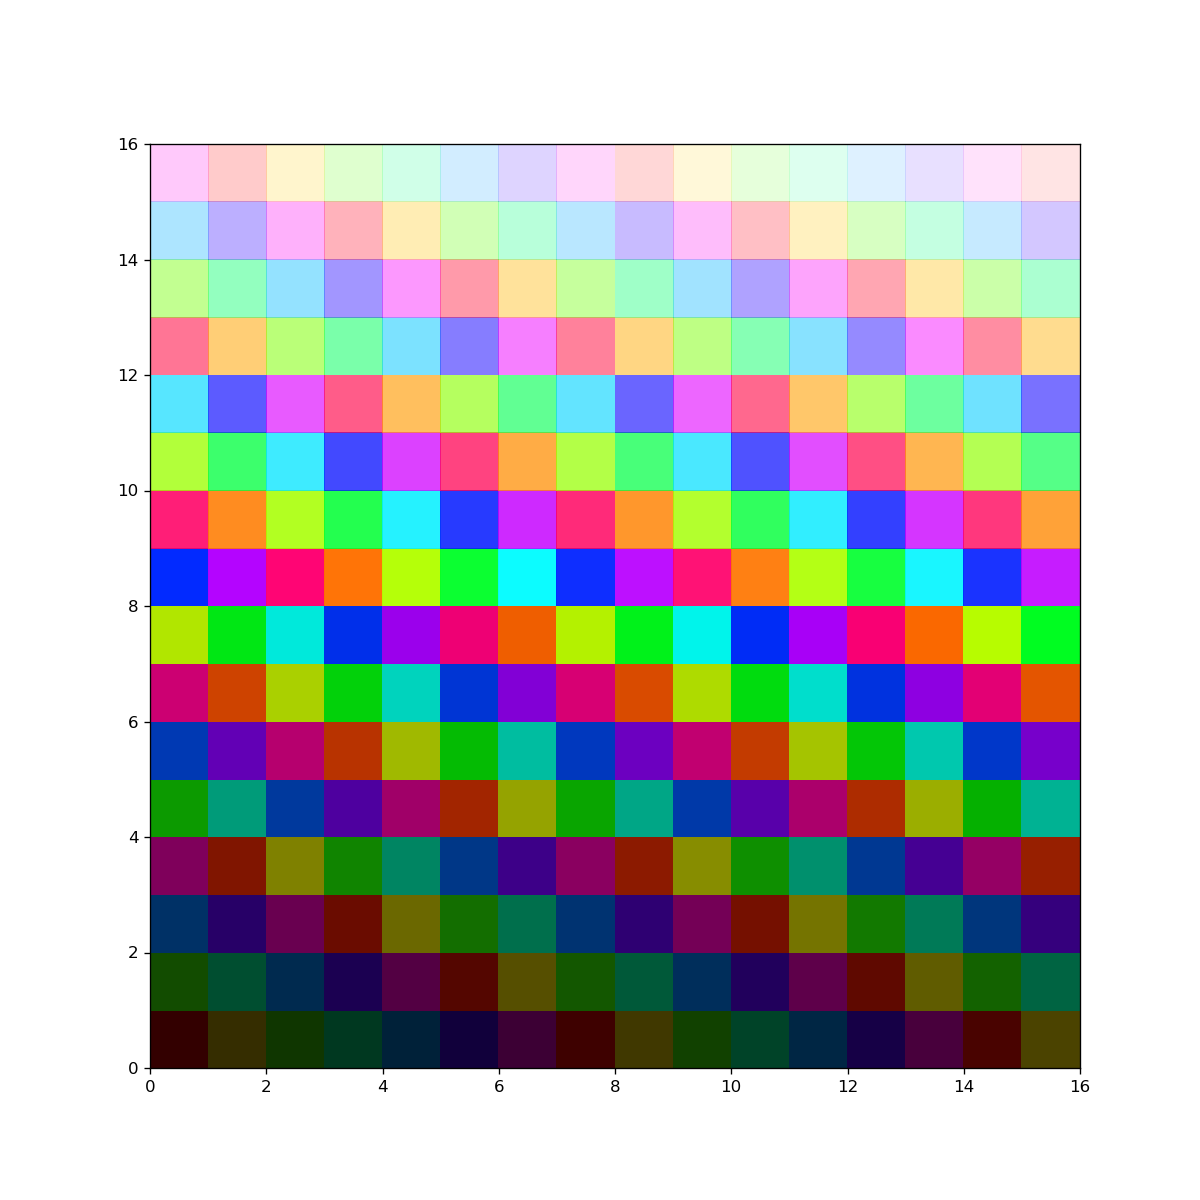

In [5]:
from matplotlib.colors import ListedColormap

# plt.switch_backend('nbAgg')
def generate_colormap(N):
    S = 7
    arr = np.arange(N)/N
    N_up = int(np.ceil(N/S)*S)
    arr.resize(N_up)
    arr = arr.reshape(S,N_up//S).T.reshape(-1)
    ret = matplotlib.cm.hsv(arr)
    n = ret[:,3].size
    a = n//2
    b = n-a
    for i in range(3):
        ret[0:n//2,i] *= np.arange(0.2,1,0.8/a)
    ret[n//2:,3] *= np.arange(1,0.1,-0.9/b)
#     print(ret)
    return ret

N = 16
H = np.arange(N*N).reshape([N,N])
fig = plt.figure(figsize=(10, 10))
ax = plt.pcolor(H, cmap=ListedColormap(generate_colormap(N*N)))